In [ ]:
pip install implicit

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from implicit.als import AlternatingLeastSquares
from implicit import nearest_neighbours
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_file_path(category):
  return f'/content/drive/MyDrive/ShoppingPulse/datasets/raw/interactions_train/flattened_data_{category}.parquet'

def validation_file_path(category):
  return f'/content/drive/MyDrive/ShoppingPulse/datasets/raw/interactions_valid/flattened_data_{category}.parquet'

In [ ]:
def collaborative_filtering_svd(category, k=50, lambda_reg=0.1):
    dataset_path = train_file_path(category)
    df = pd.read_parquet(dataset_path)

    df['user_id'] = df['user_id'].astype(str)
    df['parent_asin'] = df['parent_asin'].astype(str)
    df['rating'] = df['rating'].astype(float)

    user_item_matrix = df.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)
    R = user_item_matrix.values

    mean_rating = np.mean(R[R != 0])
    R_reg = R - mean_rating

    U, sigma, Vt = svds(R_reg, k=k)
    sigma = np.diag(sigma)

    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + mean_rating

    predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

    return predicted_ratings_df

In [ ]:
category = 'Gift_Cards'
k = 50

predicted_ratings_df = collaborative_filtering_svd(category, k=k)

print(predicted_ratings_df)

parent_asin                   1619923009  B00067G16E  B000VFA4BY  B001GXRQW0  \
user_id                                                                        
AE225J6Y3OFUCKVVCRDHXLZKDULA   -0.000401   -0.000427   -0.000509    0.002834   
AE22EOOOTMJOODRKZEOCVDODY4GA   -0.000948   -0.001056   -0.001266    0.002404   
AE22HVB2CJ27FBMLD6PBNZ3KLHUQ    0.002134    0.001923    0.001356    0.024432   
AE22LNDYO5VO3ZPRC4SO4HTXLQHQ    0.000100    0.000056    0.000026   -0.001448   
AE22LYKDYTYNPV7M4SGSDIGUQY7Q   -0.001629   -0.001830   -0.002435    0.016406   
...                                  ...         ...         ...         ...   
AHZZWDFRRAR5P43PBUMDDCXO2DTQ   -0.001573   -0.001706   -0.001900   -0.002852   
AHZZX33LWQAIOABECYVVD5VI5MXA   -0.000040   -0.000039   -0.000005   -0.000085   
AHZZXXX7OJX266FSIET6OU4BEBSA   -0.000680   -0.000719   -0.000826    0.001500   
AHZZYQXZBHX3G3BQEENWOMJYYXDQ   -0.000040   -0.000039   -0.000005   -0.000085   
AHZZYWIJWBW5T5ICUWIMQS3WWTSA   -0.000040

In [ ]:
def collaborative_filtering_als(category, k=50, iterations=10, lambda_reg=0.01):
    dataset_path = train_file_path(category)
    df = pd.read_parquet(dataset_path)

    df['user_id'] = df['user_id'].astype(str)
    df['parent_asin'] = df['parent_asin'].astype(str)
    df['rating'] = df['rating'].astype(float)
    df['timestamp'] = df['timestamp'].apply(lambda x: pd.Timestamp(int(x), unit='ms'))

    sparse_matrix = df.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)
    R = sparse_matrix.values

    R_sparse = csr_matrix(R)

    model = AlternatingLeastSquares(factors=k, iterations=iterations, regularization=lambda_reg)

    model.fit(R_sparse)

    U = model.user_factors
    V = model.item_factors

    predicted_ratings = np.dot(U, V.T)

    predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=sparse_matrix.columns, index=sparse_matrix.index)

    return predicted_ratings_df, R_sparse

In [ ]:
def evaluate_recommendations(predicted_ratings_df, sparse_matrix, validation_df):
    users_in_both = set(predicted_ratings_df.index).intersection(set(validation_df['user_id']))

    recommendations = {}
    for user in users_in_both:
        sorted_items = predicted_ratings_df.loc[user].sort_values(ascending=False).index.tolist()
        recommendations[user] = sorted_items

    results = {}


    for user in users_in_both:
        recommended_items = set(recommendations[user])
        actual_purchases = set(validation_df[validation_df['user_id'] == user]['parent_asin'])
        intersection_count = len(recommended_items.intersection(actual_purchases))
        total_purchases = len(actual_purchases)
        results[user] = intersection_count / total_purchases if total_purchases > 0 else 0

    return results

In [ ]:
category = 'Gift_Cards'
k = 50

predicted_ratings_df, sparse_matrix = collaborative_filtering_als(category, k=k)

validation_path = validation_file_path(category)
validation_df = pd.read_parquet(validation_path)

validation_df['user_id'] = validation_df['user_id'].astype(str)
validation_df['parent_asin'] = validation_df['parent_asin'].astype(str)
validation_df['rating'] = validation_df['rating'].astype(float)
validation_df['timestamp'] = validation_df['timestamp'].apply(lambda x: pd.Timestamp(int(x), unit='ms'))

results, zeros_count, ones_count = evaluate_recommendations(predicted_ratings_df, sparse_matrix, validation_df)

  0%|          | 0/10 [00:00<?, ?it/s]

5.0
0.0


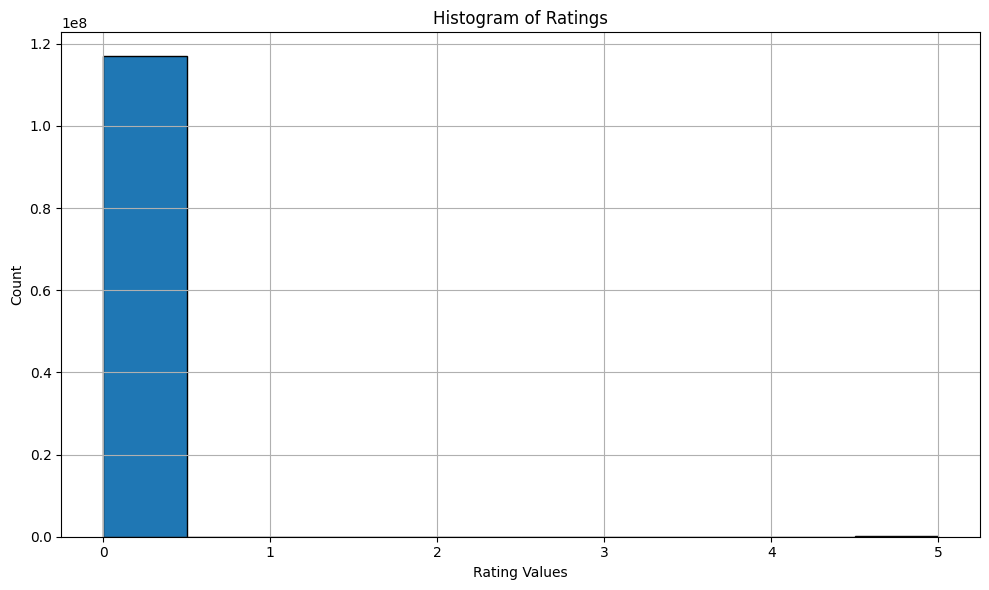

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ratings_histogram(R_sparse):
    # Convert sparse matrix to dense matrix (if necessary)
    R = R_sparse.toarray() if isinstance(R_sparse, csr_matrix) else R_sparse

    # Flatten the matrix into a 1D array of ratings
    ratings = R.flatten()

    # Determine min and max ratings
    min_rating = np.min(ratings)
    max_rating = np.max(ratings)

    print(max_rating)
    print(min_rating)

    # Split range into 10 intervals
    intervals = np.linspace(min_rating, max_rating, num=11)

    # Count ratings in each interval
    counts, _ = np.histogram(ratings, bins=intervals)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(ratings, bins=intervals, edgecolor='black')
    plt.title('Histogram of Ratings')
    plt.xlabel('Rating Values')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming R_sparse is your sparse matrix obtained from collaborative filtering
plot_ratings_histogram(sparse_matrix)
